In [1]:
pip install -q trl evaluate peft sacrebleu

Note: you may need to restart the kernel to use updated packages.


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")
import wandb
wandb.login(key=wandb_api)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt 

from urllib.request import urlopen
import io
from IPython.display import Markdown
def display_markdown(string):
    display(Markdown(string))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
class CFG:
    
    model_path = "../input/instruction-tuning-with-llm-output"
    
    load_model = True
    
    is_training = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")
dataset

README.md:   0%|          | 0.00/677 [00:00<?, ?B/s]

(…)-00000-of-00001-e270777bb989ac86.parquet:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

Take a look at sample data

In [6]:
dataset[200]

{'instruction': 'Describe the role of the constructors in  a Java class.',
 'input': '',
 'output': 'The role of the constructors in a Java class is to initialize the fields of an object. A constructor is a special method that is called when an object is instantiated. Constructors typically have the same name as the class and take in parameters. The parameters are used to initialize the fields of the object. Constructors are important because they allow us to create uniform objects with a well-defined state. Constructors can also be used to set up desired behaviors on objects and to make sure they are initialized properly.'}

To keep things simple, use data without input and shuffle the dataset.

In [ ]:
dataset = dataset.filter(lambda example: example["input"] == '').shuffle(seed=42)

The CodeAlpaca 20k dataset has a training and test set. You can split the original training data into a train and test set by assigning 80% of the data to the training set and 20% to the testing set.

In [8]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1953
    })
})

In [ ]:
# Base model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)
print(model)
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')
print(tokenizer)

In [10]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts

In [11]:
expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)

  0%|          | 0/1953 [00:00<?, ?it/s]

Let's look at the example to view what `instructions` include, `instructions_with_responses`, and `expected_outputs`:


Instead of keeping the instructions as-is, it's beneficial to convert the `instructions` list into a `torch` `Dataset`. Define a class called `ListDataset` that inherits from `Dataset` and creates a `torch` `Dataset` from a list. This class is then used to generate a `Dataset` object from `instructions`: 


In [13]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list
    
    def __len__(self):
        return len(self.original_list)
    
    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

Take a look at data.

In [15]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

The below code leverages the pre-defined generation pipeline to generate outputs using the model. Due to resource constraint, only evaluate first 100 samples.

In [16]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_torch[:100], 
                                    max_length=512,
                                    num_beams=5,
                                    early_stopping=True)

generated_outputs_base = []
for text in tqdm(pipeline_iterator):
    generated_outputs_base.append(text[0]["generated_text"])

  0%|          | 0/100 [00:00<?, ?it/s]

Let's look at the sample responses generated by the base model and the expected responses from the dataset.


In [17]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')
    

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:




@@@@@ Expected response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".



@@@@@ Generated response 1: 
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:
What type of d

In [18]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs[:len(generated_outputs_base)])

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.4


In [19]:
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config)

In [20]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 512, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
          (project_out): Linear(in_features=1024, out_features=512, bias=False)
          (project_in): Linear(in_features=512, out_features=1024, bias=False)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False)

Load previous trained model if necessary. It could be used to continuous training.

In [21]:
if CFG.load_model:
    state_dict = torch.load(f"{CFG.model_path}/pytorch_model.bin")
    model.load_state_dict(state_dict)

In [22]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [23]:
if CFG.is_training:
    training_args = SFTConfig(
        output_dir="./tmp",
        num_train_epochs=3,
        save_strategy="epoch",
        fp16=True,
        per_device_train_batch_size=2,  # Reduce batch size
        per_device_eval_batch_size=2,  # Reduce batch size
        max_seq_length=1024,
        do_eval=True,
        save_safetensors=False
    )
    trainer = SFTTrainer(
        model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        formatting_func=formatting_prompts_func,
        args=training_args,
        packing=False,
        data_collator=collator
    )
    trainer.train()
    torch.save(trainer.model.state_dict(), "./pytorch_model.bin")

Map:   0%|          | 0/7811 [00:00<?, ? examples/s]

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: lonnieqin. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241021_075445-zj6vgbe2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./tmp
wandb: ⭐️ View project at https://wandb.ai/lonnieqin/huggingface
wandb: 🚀 View run at https://wandb.ai/lonnieqin/huggingface/runs/zj6vgbe2


Step,Training Loss
500,1.571600
1000,1.468600
1500,1.529300
2000,1.600900
2500,1.544000
3000,1.586400
3500,1.560300
4000,1.538900
4500,1.536400
5000,1.525100


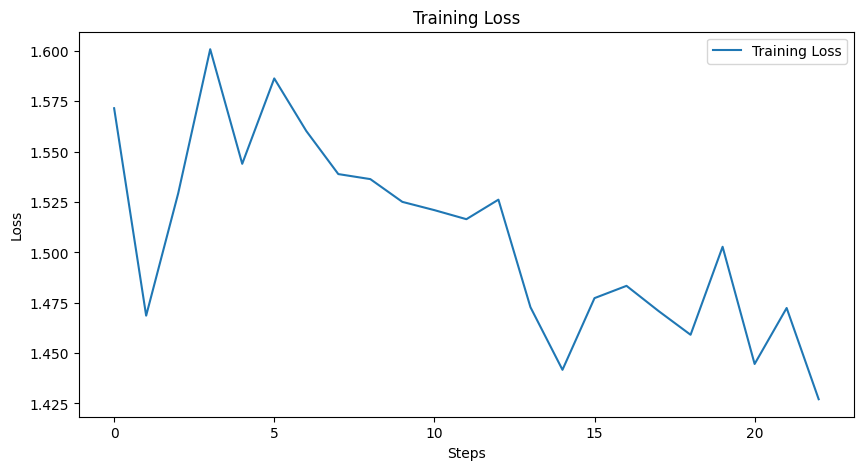

In [24]:
if CFG.is_training:
    log_history_lora = trainer.state.log_history

    train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [25]:
%%time
gen_pipeline = pipeline("text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        device=device, 
                        batch_size=2, 
                        max_length=50, 
                        truncation=True, 
                        padding=False,
                        return_full_text=False)


with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_torch[0:100],
                                max_length=512,
                                num_beams=5,
                                early_stopping=True)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

CPU times: user 6min 11s, sys: 244 ms, total: 6min 11s
Wall time: 6min 11s


In [26]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs[:len(generated_outputs_lora)])
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
11.4
